# NLP Disaster Tweets Kaggle Mini-Project

Plan:
- EDA
- Data Preprocessing
  - Tokenization
  - Stopword Removal
  - (some other stuff based on EDA)
  - Lemmatization
  - Vectorization
- Model Training
  - Baseline Model (Vanilla RNN)
  - LSTM
  - GRU (Maybe)
  - Fine-tuning (pre-trained embeddings, hyperparameter tuning)?
  - (maybe some transformer model if time permits)
- Model Evaluation
  - Accuracy
  - Precision, Recall, F1-Score
  - Confusion Matrix
- Conclusion and Future Work

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from cleantext import clean
import html
import torch
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split


In [5]:
DATA_DIR = "./data"
SEED = 42

## EDA

In [3]:
df = pd.read_csv(f"{DATA_DIR}/train.csv")
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
df.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


Positive samples: 3271
Negative samples: 4342


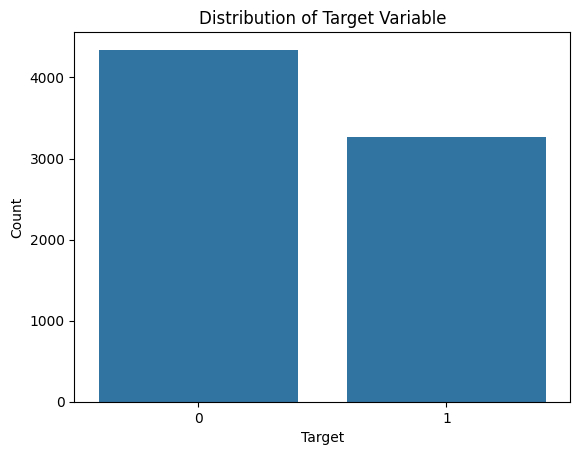

In [6]:
positive = df[df['target'] == 1]
negative = df[df['target'] == 0]
print(f"Positive samples: {len(positive)}")
print(f"Negative samples: {len(negative)}")

# plot the distribution of target variable
sns.countplot(x='target', data=df)
plt.title('Distribution of Target Variable')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

In [7]:
duplicated_rows = df.duplicated()

duplicates_texts = df.duplicated(subset=["text"])

print(f"Duplicate tweets: {duplicates_texts.sum()}, duplicated rows: {duplicated_rows.sum()}")


Duplicate tweets: 110, duplicated rows: 0


In [8]:
df.duplicated(subset=["text"]).groupby(df['target']).sum()

target
0    37
1    73
dtype: int64

In [9]:
df[df["id"].isin(df[duplicates_texts]["id"])].sort_values("text")

,id,keyword,location,text,target
4299,6105,hellfire,?????? ??? ?????? ????????,#Allah describes piling up #wealth thinking it...,0
4312,6123,hellfire,?????? ???? ??????,#Allah describes piling up #wealth thinking it...,1
6366,9098,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
6373,9107,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
6392,9135,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
...,...,...,...,...,...
3461,4952,exploded,NaN,that exploded &amp; brought about the\nbeginni...,0
6103,8714,sinking,NaN,that horrible sinking feeling when youÛªve be...,0
6094,8702,sinking,NaN,that horrible sinking feeling when youÛªve be...,0
6123,8739,sinking,MA,that horrible sinking feeling when youÛªve be...,1


## Data Preprocessing


In [6]:
train_df = pd.read_csv(f"{DATA_DIR}/train.csv")
test_df = pd.read_csv(f"{DATA_DIR}/test.csv")

In [7]:
MENTION_RE = re.compile(r'@\w+')
HASHTAG_RE = re.compile(r'#(\w+)')
RT_RE = re.compile(r'\brt\b', flags=re.IGNORECASE)

def clean_tweet(text):
    s = "" if text is None else str(text)
    # decode HTML entities
    s = html.unescape(s)

    # 2) general cleanup using clean-text library
    s = clean(
        s,
        lower=True,
        no_urls=True,
        no_emails=True,
        fix_unicode=True,
        no_emoji=True,
        no_line_breaks=True,
        no_currency_symbols=True,
        no_punct=False,
        replace_with_url="",
        replace_with_email=""
    )

    # 3) tweet-specific rules
    s = MENTION_RE.sub("", s)         # remove @mentions
    s = HASHTAG_RE.sub(r"\1", s)      # keep hashtag word, drop '#'
    s = RT_RE.sub("", s)              # remove RT token

    # 4) normalize whitespace
    s = " ".join(s.split())
    return s

train_df['cleaned_text'] = train_df['text'].apply(clean_tweet)


In [8]:
print(train_df[train_df['id'] == 9278]['text'].values[0])
print("-----")
print(train_df[train_df['id'] == 9278]['cleaned_text'].values[0])

&lt;&lt; his lip as he sunk into the bed his arms crossed behind his head as he watched his Captain do a number on his body. @ResoluteShield
-----
<< his lip as he sunk into the bed his arms crossed behind his head as he watched his captain do a number on his body.


## Tokenization

In [9]:
class TweetDataset(Dataset):
    def __init__(self, df, max_len=32):
        self.texts = df['cleaned_text'].tolist()
        self.labels = df['target'].tolist()
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoded = encode(self.texts[idx])
        padded = encoded[:self.max_len] + [0]*(self.max_len - len(encoded))
        return torch.tensor(padded), torch.tensor(self.labels[idx])

# pytorch vanilla rnn for tweets


In [20]:


# Simple tokenizer and vocab builder
def tokenize(text):
    return text.split()

vocab = set()
for text in train_df['cleaned_text']:
    vocab.update(tokenize(text))
word2idx = {word: idx+1 for idx, word in enumerate(vocab)}  # 0 for padding

def encode(text):
    return [word2idx.get(word, 0) for word in tokenize(text)]

# Prepare dataset


dataset = TweetDataset(train_df)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Vanilla RNN model
class VanillaRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim=64, hidden_dim=64, num_classes=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size+1, embed_dim, padding_idx=0)
        self.rnn = nn.RNN(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        _, h_n = self.rnn(x)
        out = self.fc(h_n.squeeze(0))
        return out

model = VanillaRNN(len(word2idx))

In [29]:

X = train_df["text"]
y = train_df["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=SEED)


In [24]:
from sklearn.metrics import f1_score

best_f1 = 0
patience = 3
patience_counter = 0

torch.manual_seed(SEED)

device = "mps"
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
best_model_state = {}

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for batch_x, batch_y in dataloader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == batch_y).sum().item()
        total += batch_y.size(0)
    avg_loss = total_loss / len(dataloader)
    train_acc = correct / total

    # Validation on train set (since no val split yet)
    model.eval()
    val_correct = 0
    val_total = 0
    all_probs = []
    all_labels = []
    all_val_preds = []
    with torch.no_grad():
        for batch_x, batch_y in dataloader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            preds = torch.argmax(outputs, dim=1)
            val_correct += (preds == batch_y).sum().item()
            val_total += batch_y.size(0)
            all_probs.extend(probs)
            all_labels.extend(batch_y.cpu().numpy())
            all_val_preds.extend(preds.cpu().numpy())
    val_acc = val_correct / val_total
    auc = roc_auc_score(all_labels, all_probs)
    f1 = f1_score(all_labels, all_val_preds)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, AUC: {auc:.4f}, F1: {f1:.4f}")

    # Early stopping based on F1 score
    if f1 > best_f1:
        best_f1 = f1
        patience_counter = 0
        best_model_state = model.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}. Best F1: {best_f1:.4f}")
            model.load_state_dict(best_model_state)
            break

print(f"best model state: {best_model_state}")

Epoch 1/10, Loss: 0.3949, Train Acc: 0.8270, Val Acc: 0.8617, AUC: 0.9315, F1: 0.8360
Epoch 2/10, Loss: 0.3460, Train Acc: 0.8564, Val Acc: 0.8704, AUC: 0.9414, F1: 0.8481
Epoch 3/10, Loss: 0.3009, Train Acc: 0.8760, Val Acc: 0.9045, AUC: 0.9629, F1: 0.8885
Epoch 4/10, Loss: 0.2620, Train Acc: 0.8965, Val Acc: 0.9113, AUC: 0.9674, F1: 0.8965
Epoch 5/10, Loss: 0.2427, Train Acc: 0.9041, Val Acc: 0.9023, AUC: 0.9617, F1: 0.8857
Epoch 6/10, Loss: 0.2167, Train Acc: 0.9136, Val Acc: 0.9329, AUC: 0.9807, F1: 0.9213
Epoch 7/10, Loss: 0.1932, Train Acc: 0.9259, Val Acc: 0.9392, AUC: 0.9814, F1: 0.9291
Epoch 8/10, Loss: 0.1645, Train Acc: 0.9376, Val Acc: 0.9447, AUC: 0.9867, F1: 0.9352
Epoch 9/10, Loss: 0.1454, Train Acc: 0.9468, Val Acc: 0.9590, AUC: 0.9914, F1: 0.9519
Epoch 10/10, Loss: 0.1409, Train Acc: 0.9480, Val Acc: 0.9573, AUC: 0.9910, F1: 0.9501
best model state: OrderedDict({'embedding.weight': tensor([[ 0.0564, -0.0120, -0.0172,  ...,  0.0173, -0.0552,  0.0119],
        [ 0.8125, 

AUC: 0.9910


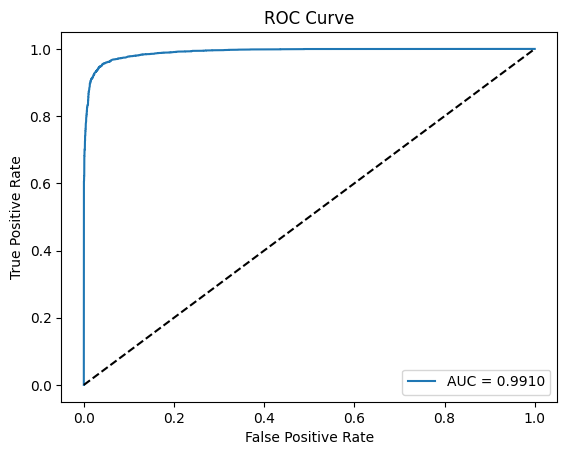

/var/folders/7_/b5vyj4yn7d71c_559xynhb300000gn/T/ipykernel_97038/2865187515.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  disp.plot(cmap=plt.cm.get_cmap("Blues"))


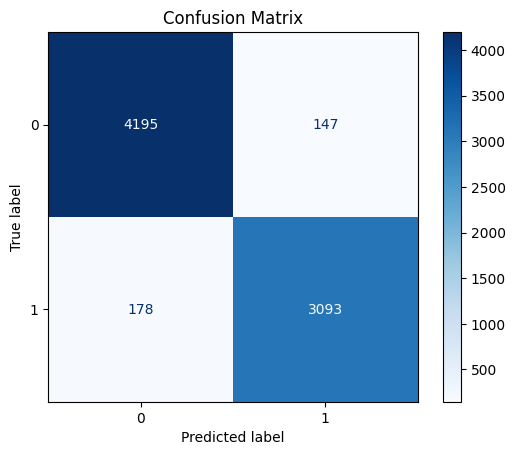

In [ ]:

# Collect predictions and true labels from the training set

model.eval()
all_preds = []
all_probs = []
all_labels = []

with torch.no_grad():
    for batch_x, batch_y in dataloader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x)
        probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_probs.extend(probs)
        all_preds.extend(preds)
        all_labels.extend(batch_y.cpu().numpy())

# AUC score
auc = roc_auc_score(all_labels, all_probs)
print(f"AUC: {auc:.4f}")

# ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.get_cmap("Blues"))
plt.title('Confusion Matrix')
plt.show()